# RNN stock price predictor

Using Recurrent neural network (RNN) and Long short-term memory (LSTM) algorithm, one of deep learning technique, we'll predict selected ticker's future price. 

Note : This is just a basic code, hence it's not suitable to apply in real life market, and any investment should be your own decision also risk you take.





## Recurrent Neural Network (RNN)

Recurrent neural networks (RNN) are the state of the art algorithm for sequential data and are used by Apple's Siri and and Google's voice search. In RNN, neuron is called cell, information of previously trained cell is used for next cell, hence it is suitable to process sequential data.

[image : RNN]

## Long short-term memory

RNN can store short-term memory, to find correlations of data, it needs long term memory, LSTM is used to support 
this.

A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.


## Stock price predictor


### data cleansing

In [25]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
# To prevent TF complier error
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Model
import tensorflow as tf
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, Bidirectional, Activation
from keras.models import Sequential


    
def get_tickers(ticker):
    data = yf.Ticker(ticker)
    x = data.history(period='max', auto_adjust=True)
#     x = pdr.get_data_yahoo(tickers, start=date_from)
    df = pd.DataFrame(x[['Open', 'High', 'Low', 'Volume', 'Close']])
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.rename(columns={'Close' : 'Close'}, inplace=True)
    return df

def Normalizer(data):
    numerator = data - np.min(data,0)
    denominator = np.max(data, 0) - np.min(data,0)
    return numerator / (denominator + 1e-7)

In [50]:
tickers = 'SPY'
df = get_tickers(tickers)
df

,Open,High,Low,Volume,Close
Date,,,,,
1993-01-29,25.818120,25.818120,25.689672,1003200,25.799770
1993-02-01,25.818125,25.983273,25.818125,480500,25.983273
1993-02-02,25.964916,26.056665,25.909866,201300,26.038315
1993-02-03,26.075019,26.331916,26.056669,529400,26.313566
1993-02-04,26.405305,26.478704,26.111709,531500,26.423655
...,...,...,...,...,...
2021-07-20,425.679993,432.420013,424.829987,99608200,431.059998
2021-07-21,432.339996,434.700012,431.010010,64724400,434.549988
2021-07-22,434.739990,435.720001,433.690002,47878500,435.459991


In [27]:
dfx = Normalizer(df)
dfy = dfx[['Close']]


x = dfx.values.tolist()
y = dfy.values.tolist()

In [28]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7174 entries, 1993-01-29 to 2021-07-26
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    7174 non-null   float64
 1   High    7174 non-null   float64
 2   Low     7174 non-null   float64
 3   Volume  7174 non-null   float64
 4   Close   7174 non-null   float64
dtypes: float64(5)
memory usage: 336.3 KB


In [29]:
dfy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7174 entries, 1993-01-29 to 2021-07-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   7174 non-null   float64
dtypes: float64(1)
memory usage: 112.1 KB


In [30]:
data_x = []
data_y = []
window_size = 10
for i in range(len(y) - window_size):
    _x = x[i : i + window_size] # not including next day close (i+window_size)
    _y = y[i + window_size] # Next day close
    data_x.append(_x)
    data_y.append(_y)

Run `print(_x, "->", _y)` to see _x values added to data_x and _y

In [31]:
print(_x, "->", _y)

[[0.9906239799885092, 0.9911425526376642, 0.9896406836066197, 0.06071540632023724, 0.9905181765945881], [0.9925813365775537, 0.9923219198194689, 0.9904616911915272, 0.06074031960879018, 0.9869324367049155], [0.9953844818305931, 0.9925145145348833, 0.9894958042500154, 0.07362071940622333, 0.9884966812139712], [0.9891257637100438, 0.9867619410290148, 0.9842074866566097, 0.06328342677347311, 0.9849109413242986], [0.9920255894878454, 0.9880376055685268, 0.9798609585735818, 0.0870007626680915, 0.9767045881059606], [0.9682955722345891, 0.9768454433326786, 0.9582488790065625, 0.16989462138173228, 0.9613748597213312], [0.9670631352171785, 0.9792764558045901, 0.9651550406461991, 0.11435199445799876, 0.9760307563124216], [0.983157013418148, 0.9847642299401045, 0.9800782776084882, 0.07430267762744208, 0.9844296014251319], [0.9889565912281182, 0.9872192616614212, 0.986549801178312, 0.05496227358900949, 0.9866195731146729], [0.9956744496592467, 0.9982429218846224, 0.9940355539368156, 0.073163210397

Past 10 days, given data, latest close is 0.8726370803053053, next day close is 0.8677396475977315

### Prepare train / test dataset

In [32]:
# train dataset
train_size = int(len(data_y) * 0.7)
train_x = np.array(data_x[0 : train_size])
train_y = np.array(data_y[0 : train_size])

# test dataset
test_size = len(data_y) - train_size
test_x = np.array(data_x[train_size : len(data_x)])
test_y = np.array(data_y[train_size : len(data_y)])

### Build model with SimpleRNN

In [33]:
model_rnn = Sequential()

model_rnn.add(SimpleRNN(units = 20, activation='relu',
                   return_sequences=True, input_shape=(window_size, 5)))
model_rnn.add(Dropout(0.1))
model_rnn.add(SimpleRNN(units=40, activation='relu'))
model_rnn.add(Dropout(0.1))
model_rnn.add(Dense(units=1))
model_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 10, 20)            520       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 20)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 40)                2440      
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________


### Model fit

In [34]:
model_rnn.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])
history = model_rnn.fit(train_x, train_y, epochs=30, batch_size=30)
pred_y = model_rnn.predict(test_x)

Epoch 1/30
168/168 [==============================] - 1s 1ms/step - loss: 0.0065 - accuracy: 1.4204e-04
Epoch 2/30
168/168 [==============================] - 0s 1ms/step - loss: 4.2450e-04 - accuracy: 1.9680e-04
Epoch 3/30
168/168 [==============================] - 0s 1ms/step - loss: 2.9971e-04 - accuracy: 2.4279e-04
Epoch 4/30
168/168 [==============================] - 0s 1ms/step - loss: 2.0957e-04 - accuracy: 3.9829e-04
Epoch 5/30
168/168 [==============================] - 0s 1ms/step - loss: 1.7859e-04 - accuracy: 3.5413e-06
Epoch 6/30
168/168 [==============================] - 0s 1ms/step - loss: 1.6275e-04 - accuracy: 3.3194e-04
Epoch 7/30
168/168 [==============================] - 0s 1ms/step - loss: 1.4051e-04 - accuracy: 7.6466e-04
Epoch 8/30
168/168 [==============================] - 0s 1ms/step - loss: 1.2289e-04 - accuracy: 5.6180e-05
Epoch 9/30
168/168 [==============================] - 0s 1ms/step - loss: 1.2019e-04 - accuracy: 2.9755e-04
Epoch 10/30
168/168 [===========

### Compare prediction to real

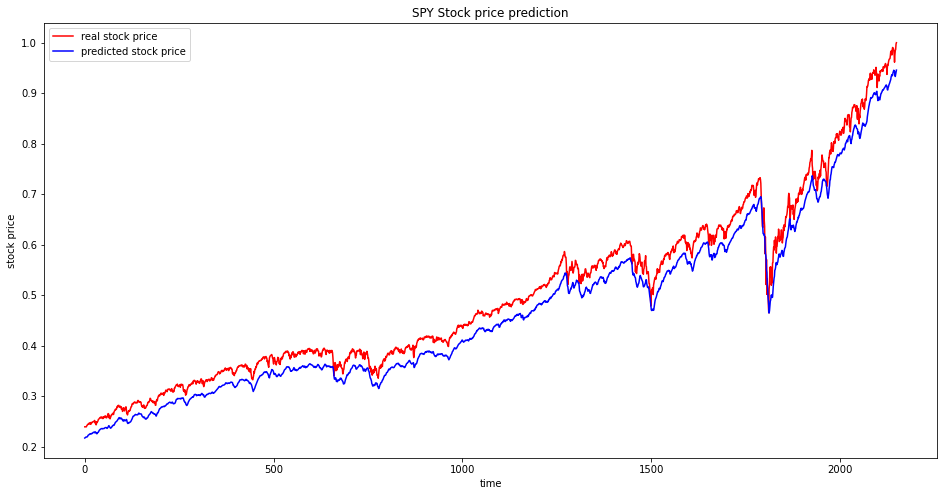

In [35]:
plt.figure(figsize=(16,8))
plt.plot(test_y, c='r', label='real stock price')
plt.plot(pred_y, c='blue', label='predicted stock price')
plt.title(f'{tickers} Stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

### Build model with LSTM

In [36]:
# model = keras.Sequential()
# model.add(layers.LSTM(units=10, activation='relu',
#                       return_sequences=True, input_shape=(window_size, 5)))
# model.add(layers.Dropout(0.1))
# model.add(layers.LSTM(units=10, activation='relu'))
# model.add(layers.Dropout(0.1))
# model.add(layers.Dense(units=1))
# model.summary()

model_lstm = Sequential()
model_lstm.add(LSTM(units=64, activation='relu',
                   return_sequences=True, input_shape=(window_size, 5)))
model_lstm.add(LSTM(units=64, activation='relu',
                   return_sequences=False))
model_lstm.add(Dense(units=32))
model_lstm.add(Dense(units=1))
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 64)            17920     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 53,057
Trainable params: 53,057
Non-trainable params: 0
_________________________________________________________________


In [37]:
model_lstm.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy'])
history2 = model_lstm.fit(train_x, train_y, epochs=30, batch_size=30)
pred_y2 = model_lstm.predict(test_x)

Epoch 1/30
168/168 [==============================] - 2s 4ms/step - loss: 0.0025 - accuracy: 1.4502e-05
Epoch 2/30
168/168 [==============================] - 1s 4ms/step - loss: 2.0824e-05 - accuracy: 1.0116e-04
Epoch 3/30
168/168 [==============================] - 1s 4ms/step - loss: 2.1862e-05 - accuracy: 1.8456e-04
Epoch 4/30
168/168 [==============================] - 1s 4ms/step - loss: 1.7993e-05 - accuracy: 9.2903e-04
Epoch 5/30
168/168 [==============================] - 1s 4ms/step - loss: 1.9914e-05 - accuracy: 5.9020e-04
Epoch 6/30
168/168 [==============================] - 1s 4ms/step - loss: 1.9123e-05 - accuracy: 9.9228e-05
Epoch 7/30
168/168 [==============================] - 1s 4ms/step - loss: 1.8937e-05 - accuracy: 1.0509e-04
Epoch 8/30
168/168 [==============================] - 1s 4ms/step - loss: 1.7238e-05 - accuracy: 1.3732e-04
Epoch 9/30
168/168 [==============================] - 1s 4ms/step - loss: 1.9418e-05 - accuracy: 2.7440e-05
Epoch 10/30
168/168 [===========

### Compare prediction to real

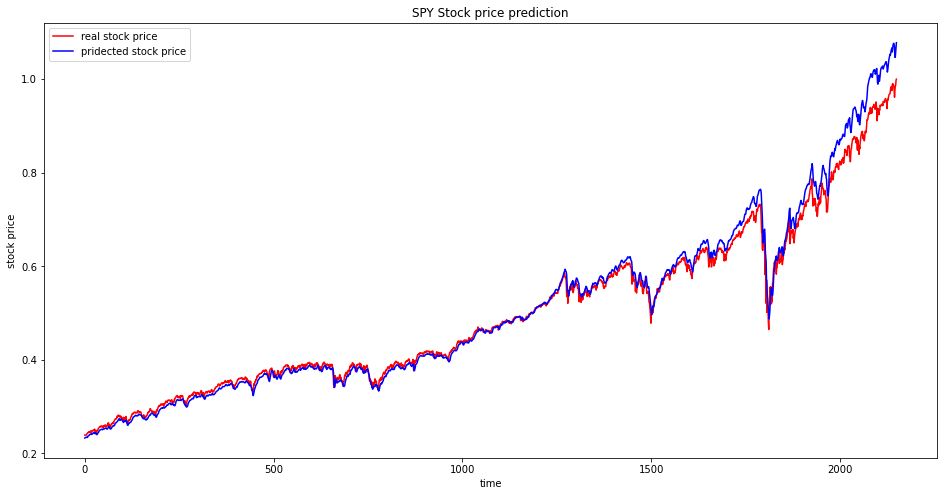

In [38]:
plt.figure(figsize=(16,8))
plt.plot(test_y, c='r', label='real stock price')
plt.plot(pred_y2, c='blue', label='pridected stock price')
plt.title(f'{tickers} Stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

## Evaluating Model

In [39]:
# Losses
history.history['loss'];

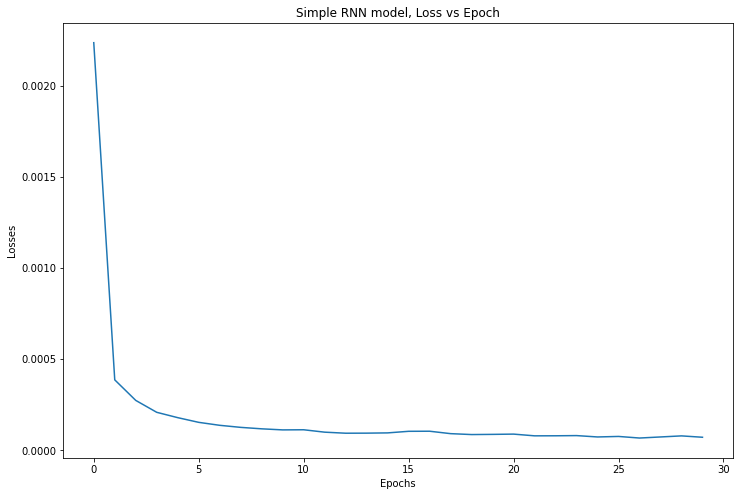

In [40]:
# plot loss vs epochs
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Simple RNN model, Loss vs Epoch')
plt.show()

In [41]:
history2.history['loss'];

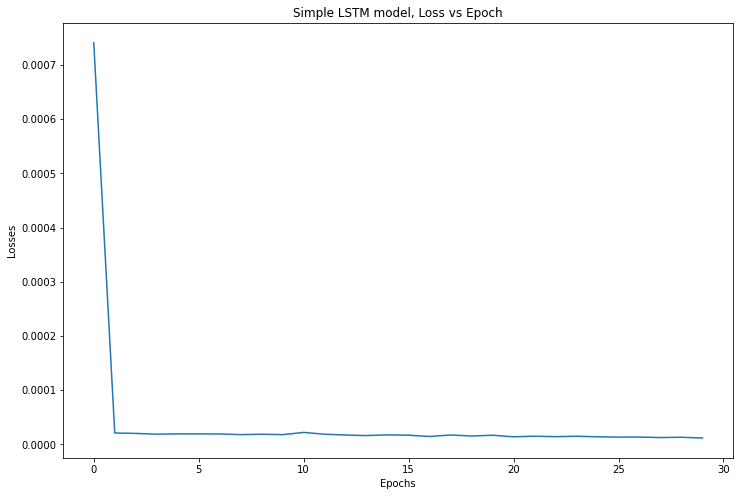

In [42]:
# plot loss vs epochs
plt.figure(figsize=(12,8))
plt.plot(history2.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Simple LSTM model, Loss vs Epoch')
plt.show()

## Predict with Prophet

In [51]:
df2 = df.reset_index()
pr_df = df2.rename(columns={'Date':'ds', 'Close':'y'})
pr_df.head()

,ds,Open,High,Low,Volume,y
0,1993-01-29,25.818120,25.818120,25.689672,1003200,25.799770
1,1993-02-01,25.818125,25.983273,25.818125,480500,25.983273
2,1993-02-02,25.964916,26.056665,25.909866,201300,26.038315
3,1993-02-03,26.075019,26.331916,26.056669,529400,26.313566
4,1993-02-04,26.405305,26.478704,26.111709,531500,26.423655


In [52]:
from prophet import Prophet
m = Prophet(daily_seasonality=False)
m.fit(pr_df)

Initial log joint probability = -296.772


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         21248    0.00417296       4069.72           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       22076.8   0.000215348       1686.41      0.6526      0.6526      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       22359.2     0.0662453       1150.12           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       22451.4     0.0388079       6676.41           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       22629.3   0.000908597       1118.93           1           1      558   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [53]:
future = m.make_future_dataframe(1, freq='D')
forecast = m.predict(future)

In [54]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
7170,2021-07-21,369.275201,357.902266,385.064880,369.275201,369.275201,2.011754,2.011754,2.011754,-0.017198,-0.017198,-0.017198,2.028952,2.028952,2.028952,0.0,0.0,0.0,371.286955
7171,2021-07-22,369.371966,358.081826,385.359631,369.371966,369.371966,1.892523,1.892523,1.892523,-0.005415,-0.005415,-0.005415,1.897938,1.897938,1.897938,0.0,0.0,0.0,371.264490
7172,2021-07-23,369.468732,358.224657,384.313637,369.468732,369.468732,1.669128,1.669128,1.669128,-0.081571,-0.081571,-0.081571,1.750700,1.750700,1.750700,0.0,0.0,0.0,371.137860
7173,2021-07-26,369.759028,357.673344,383.869124,369.759028,369.759028,1.121539,1.121539,1.121539,-0.109853,-0.109853,-0.109853,1.231392,1.231392,1.231392,0.0,0.0,0.0,370.880567
7174,2021-07-27,369.855794,357.879766,383.755848,369.855794,369.855794,1.036783,1.036783,1.036783,-0.003326,-0.003326,-0.003326,1.040109,1.040109,1.040109,0.0,0.0,0.0,370.892577


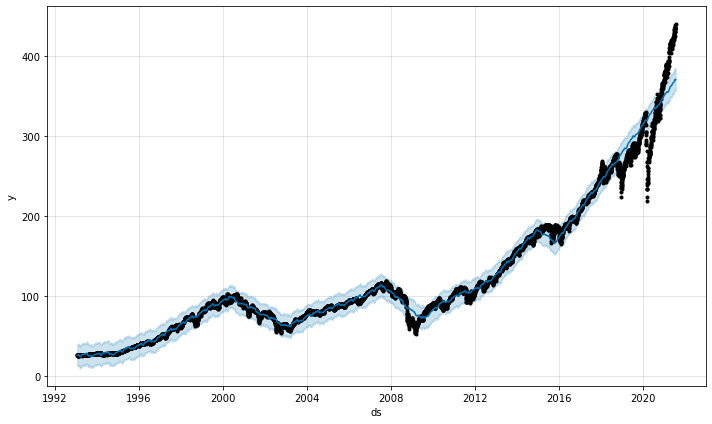

In [55]:
fig1 = m.plot(forecast)

### Predict tomorrw's close price

In [56]:
print(f'RNN predicted {tickers} tomorrow price : {df.Close[-1]*pred_y[-1]/dfy.Close[-1]}')

RNN predicted SPY tomorrow price : [417.07364]


In [57]:
print(f'LSTM predicted {tickers} tomorrow price : {df.Close[-1]*pred_y2[-1]/dfy.Close[-1]}')

LSTM predicted SPY tomorrow price : [475.3836]


In [58]:
print(f'Prophet predicted {tickers} tomorrow price : [{forecast.loc[forecast.index[-1], "yhat"]}]')

Prophet predicted SPY tomorrow price : [370.89257720150385]
